# Impact of factors on retention

## Import libraries

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#import geopandas as gpd

Read turnover data from csv into a dataframe.

In [112]:
url = f'../01_data/processed_annual_turnover.csv'
df = pd.read_csv(url, parse_dates=['month_year'])
#df = df.sort_values(by='Date')
df = df.drop(['n'],axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181008 entries, 0 to 181007
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   org_code     181008 non-null  object        
 1   region_name  181008 non-null  object        
 2   org_type     181008 non-null  object        
 3   staff_group  181008 non-null  object        
 4   month_year   181008 non-null  datetime64[ns]
 5   join_HC      136132 non-null  float64       
 6   join_FTE     136132 non-null  float64       
 7   leave_HC     138338 non-null  float64       
 8   leave_FTE    138338 non-null  float64       
 9   denom_HC     176695 non-null  float64       
 10  denom_FTE    176695 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 15.2+ MB


Calculate a leaver and joiner rate, drop HC columns

In [113]:
df['leaver_rate'] = df['leave_FTE']/df['denom_FTE']
df['joiner_rate'] = df['join_FTE']/df['denom_FTE']

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df['leaver_rate'].fillna(0, inplace=True)
df['joiner_rate'].fillna(0, inplace=True)

df = df.drop(['join_HC','leave_HC'],axis=1)


In [114]:
#df['staff_group'].unique()

Calculate a total staff in post (SIP; all staff) FTE column for each organisation by month.

In [115]:
# Set the 'total_sip_FTE' value to be equal to the 'FTE' value for 'All staff groups' 
allstaff_fte = df.loc[df['staff_group'] == 'All staff groups',
                      ['month_year', 'org_code', 'denom_FTE']].groupby(['month_year', 'org_code'])['denom_FTE'].sum().reset_index()

allstaff_fte.rename(columns={'denom_FTE':'total_sip_FTE'},inplace=True)


df = pd.merge(df, allstaff_fte, on=['month_year', 'org_code'], how='left')
#drop denom HC
df = df.drop(['denom_HC'],axis=1)
df.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,total_sip_FTE
0,R0A,North West,Acute - Teaching,All staff groups,2017-10-01,NaN,NaN,17095.95832,0.0,0.0,17095.95832
1,R0A,North West,Acute - Teaching,All staff groups,2017-11-01,NaN,NaN,17171.25859,0.0,0.0,17171.25859
2,R0A,North West,Acute - Teaching,All staff groups,2017-12-01,NaN,NaN,17170.86679,0.0,0.0,17170.86679
3,R0A,North West,Acute - Teaching,All staff groups,2018-01-01,NaN,NaN,17240.69400,0.0,0.0,17240.69400
4,R0A,North West,Acute - Teaching,All staff groups,2018-02-01,NaN,NaN,17271.63829,0.0,0.0,17271.63829


The data show the full time equivalent (FTE) number of leavers by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) FTE averaged over the 12-month period to date.

Load data about local unemployment so we can use it as a regressor

In [116]:
url_r1 = '../01_data/ONS_localunemployment_monthly.csv'
df_r1 = pd.read_csv(url_r1, parse_dates=['Date'])

df_r1.tail()

,Date,Region,NHSE region name,%,thousands
3343,2023-03-01,North West,North West,0.030,107
3344,2023-03-01,South East,South East,0.037,177
3345,2023-03-01,South West,South West,0.031,89
3346,2023-03-01,West Midlands,Midlands,0.048,147
3347,2023-03-01,York & the Humber,North East and Yorkshire,0.038,104


In [117]:
df_r1.drop(['Region','thousands'],axis=1,inplace=True)
df_r1.rename(columns={'%':'local_unemployment','Date':'month_year',
                      'NHSE region name':'region_name'},inplace=True)
df_r1 = df_r1.sort_values('month_year')
df_r1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3348 entries, 0 to 3347
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   month_year          3348 non-null   datetime64[ns]
 1   region_name         3348 non-null   object        
 2   local_unemployment  3348 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 104.6+ KB


Add data about local unemployment at the regional level to the main dataframe

In [118]:
df_leaver_r1 = pd.merge(df, df_r1, on=['month_year', 'region_name'],how='left')
#df_leaver_r1 = df_leaver_r1.dropna()
df_leaver_r1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214437 entries, 0 to 214436
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            214437 non-null  object        
 1   region_name         214437 non-null  object        
 2   org_type            214437 non-null  object        
 3   staff_group         214437 non-null  object        
 4   month_year          214437 non-null  datetime64[ns]
 5   join_FTE            161308 non-null  float64       
 6   leave_FTE           163913 non-null  float64       
 7   denom_FTE           209468 non-null  float64       
 8   leaver_rate         214437 non-null  float64       
 9   joiner_rate         214437 non-null  float64       
 10  total_sip_FTE       214437 non-null  float64       
 11  local_unemployment  214437 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 19.6+ MB


In [119]:
df_leaver_r1 = df_leaver_r1.sort_values('month_year')
df_leaver_r1.tail()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,total_sip_FTE,local_unemployment
51829,RGR,East of England,Acute - Small,Central functions,2023-03-01,56.13333,32.89333,325.90824,0.100928,0.172237,4273.74908,0.043
176844,RXK,Midlands,Acute - Large,"Hotel, property & estates",2023-03-01,40.73998,36.48999,520.17150,0.070150,0.078320,6438.93707,0.048
176845,RXK,Midlands,Acute - Large,"Hotel, property & estates",2023-03-01,40.73998,36.48999,520.17150,0.070150,0.078320,6438.93707,0.034
142045,RVJ,South West,Acute - Large,Senior managers,2023-03-01,8.00000,8.00000,35.70000,0.224090,0.224090,7978.03820,0.031
214436,TAJ,Midlands,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",2023-03-01,165.90892,84.64213,860.73011,0.098338,0.192754,3443.25848,0.034


Load data about sickness absence to use as second regressor

In [120]:
url_r2 = '../01_data/sickness_absence.csv'
df_r2 = pd.read_csv(url_r2, parse_dates=['Date'])
trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_r2 = df_r2[~df_r2['Cluster group'].isin(trust_types_todrop)]
df_r2 = df_r2.drop(['Benchmark group','Org name',
                    'NHSE region code','Cluster group'],axis=1)
df_r2.rename(columns={'Org code':'org_code','Date':'month_year',
                      'NHSE region name':'region_name','Staff group':'staff_group'},inplace=True)
df_r2 = df_r2.reset_index(drop=True)
df_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241185 entries, 0 to 241184
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   month_year          241185 non-null  datetime64[ns]
 1   org_code            241185 non-null  object        
 2   region_name         241185 non-null  object        
 3   staff_group         241185 non-null  object        
 4   FTE days lost       241185 non-null  float64       
 5   FTE days available  241185 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 11.0+ MB


In [121]:
df_r2.tail()

,month_year,org_code,region_name,staff_group,FTE days lost,FTE days available
241180,2022-06-01,RRF,North West,Support to ST&T staff,436.00301,6546.33419
241181,2022-06-01,RVY,North West,"Hotel, property & estates",577.86664,8158.65161
241182,2022-06-01,RWE,Midlands,"Support to doctors, nurses & midwives",7081.34638,112685.24840
241183,2022-06-01,RWP,Midlands,Midwives,531.53824,6310.98954
241184,2022-06-01,RWK,London,Senior managers,38.00000,4882.41354


Add sickness absence data to the main dataframe

In [122]:
merge_cols = ['month_year', 'org_code','region_name','staff_group']
df_leaver_r2 = pd.merge(df_leaver_r1, df_r2, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
df_leaver_r2.drop_duplicates(subset=merge_cols)
df_leaver_r2.rename(columns={'FTE days lost':'fte_days_lost','FTE days available':'fte_days_available'},inplace=True)
df_leaver_r2['sickness_absence'] = df_leaver_r2['fte_days_lost']/df_leaver_r2['fte_days_available']
df_leaver_r2 = df_leaver_r2.drop(['fte_days_available'],axis=1)
df_leaver_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312901 entries, 0 to 312900
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            312901 non-null  object        
 1   region_name         312901 non-null  object        
 2   org_type            312901 non-null  object        
 3   staff_group         312901 non-null  object        
 4   month_year          312901 non-null  datetime64[ns]
 5   join_FTE            244315 non-null  float64       
 6   leave_FTE           246515 non-null  float64       
 7   denom_FTE           307932 non-null  float64       
 8   leaver_rate         312901 non-null  float64       
 9   joiner_rate         312901 non-null  float64       
 10  total_sip_FTE       312901 non-null  float64       
 11  local_unemployment  312901 non-null  float64       
 12  fte_days_lost       262330 non-null  float64       
 13  sickness_absence    262085 no

Add data about reasons for sickness absence

In [123]:
url_r3 = '../01_data/sickness_absence_reason_pivot.csv'
df_r3 = pd.read_csv(url_r3, parse_dates=['Date'])
#df_r3 = df_r3.drop(['FTE days lost'],axis=1)
df_r3.rename(columns={'Date':'month_year','Staff group':'staff_group'},inplace=True)
#df_r2 = df_r2.reset_index(drop=True)

# drop least frequent reasons for absence
df_r3 = df_r3.drop(['substance_abus','asthma',
                    'dental','blood_disorder','endocrine',
                    'eye','skin_disorders','nervous_system'],axis=1)


# Replace NaN values with 0 
df_r3 = df_r3.fillna(0)
df_r3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   month_year         1374 non-null   datetime64[ns]
 1   staff_group        1374 non-null   object        
 2   anxiety_stress     1374 non-null   float64       
 3   back_problems      1374 non-null   float64       
 4   gastro             1374 non-null   float64       
 5   gynaecological     1374 non-null   float64       
 6   headache_mig       1374 non-null   float64       
 7   infectious_dis     1374 non-null   float64       
 8   other              1374 non-null   float64       
 9   other_msk          1374 non-null   float64       
 10  pregnancy_related  1374 non-null   float64       
 11  respiratory        1374 non-null   float64       
 12  unknown            1374 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 139.

Add sickness absence reason data to main dataframe

In [124]:
merge_cols = ['month_year','staff_group']
df_leaver_r3 = pd.merge(df_leaver_r2, df_r3, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
#df_leaver_r3.drop_duplicates(subset=merge_cols)
df_leaver_r3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312901 entries, 0 to 312900
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            312901 non-null  object        
 1   region_name         312901 non-null  object        
 2   org_type            312901 non-null  object        
 3   staff_group         312901 non-null  object        
 4   month_year          312901 non-null  datetime64[ns]
 5   join_FTE            244315 non-null  float64       
 6   leave_FTE           246515 non-null  float64       
 7   denom_FTE           307932 non-null  float64       
 8   leaver_rate         312901 non-null  float64       
 9   joiner_rate         312901 non-null  float64       
 10  total_sip_FTE       312901 non-null  float64       
 11  local_unemployment  312901 non-null  float64       
 12  fte_days_lost       262330 non-null  float64       
 13  sickness_absence    262085 no

In [125]:
df_leaver_r3['month_year'].max()
#date_max = df['Date'].max()

Timestamp('2023-03-01 00:00:00')

In [126]:
# List of columns to replace NaN values with 0
#cols = ['local_unemployment','sickness_absence','leaver_rate','joiner_rate']

# Replace NaN values with 0 in the specified columns
#df_leaver_r3[cols] = df_leaver_r3[cols].fillna(0)
#Replace all NaN with 0
df_leaver_r3 = df_leaver_r3.fillna(0)


df_leaver_r3.reset_index(drop=True)
df_leaver_r3.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,...,back_problems,gastro,gynaecological,headache_mig,infectious_dis,other,other_msk,pregnancy_related,respiratory,unknown
0,RRU,London,Ambulance Trust,Senior managers,2017-08-01,0.0,0.0,53.44000,0.0,0.0,...,0.037876,0.069440,0.034951,0.015255,0.000897,0.191277,0.068421,0.017224,0.029510,0.118282
1,RX2,South East,Mental Health and Learning Disability,Nurses & health visitors,2017-08-01,0.0,0.0,970.55441,0.0,0.0,...,0.073267,0.101870,0.053582,0.027108,0.006813,0.097913,0.144763,0.045536,0.028893,0.065937
2,RJE,Midlands,Acute - Teaching,Midwives,2017-08-01,0.0,0.0,231.13332,0.0,0.0,...,0.067213,0.089435,0.066639,0.024907,0.008601,0.097594,0.139491,0.053051,0.024075,0.059241
3,RJE,Midlands,Acute - Teaching,Midwives,2017-08-01,0.0,0.0,231.13332,0.0,0.0,...,0.067213,0.089435,0.066639,0.024907,0.008601,0.097594,0.139491,0.053051,0.024075,0.059241
4,RYY,South East,Community Provider Trust,Nurses & health visitors,2017-08-01,0.0,0.0,1139.50641,0.0,0.0,...,0.073267,0.101870,0.053582,0.027108,0.006813,0.097913,0.144763,0.045536,0.028893,0.065937


Need to cut dataframe to earliest and latest data available for all fields. Do this by cutting rows where all values for key variables are zero

In [127]:
df_leaver_r3 = df_leaver_r3[~((df_leaver_r3['join_FTE'] == 0) & (df_leaver_r3['leave_FTE'] == 0) | (df_leaver_r3['sickness_absence'] == 0))]

#filtered_df = df[((df['col1'] == 0) & (df['col2'] == 0)) | ((df['col3'] == 0) & (df['col4'] == 0))]


In [128]:
df_leaver_r3.tail()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,...,back_problems,gastro,gynaecological,headache_mig,infectious_dis,other,other_msk,pregnancy_related,respiratory,unknown
312896,RGR,East of England,Acute - Small,Central functions,2023-03-01,56.13333,32.89333,325.90824,0.100928,0.172237,...,0.038566,0.092089,0.035876,0.036575,0.046031,0.096725,0.068569,0.019520,0.072583,0.041105
312897,RXK,Midlands,Acute - Large,"Hotel, property & estates",2023-03-01,40.73998,36.48999,520.17150,0.070150,0.078320,...,0.082777,0.103058,0.030960,0.017851,0.059855,0.067495,0.176257,0.008785,0.079649,0.044555
312898,RXK,Midlands,Acute - Large,"Hotel, property & estates",2023-03-01,40.73998,36.48999,520.17150,0.070150,0.078320,...,0.082777,0.103058,0.030960,0.017851,0.059855,0.067495,0.176257,0.008785,0.079649,0.044555
312899,RVJ,South West,Acute - Large,Senior managers,2023-03-01,8.00000,8.00000,35.70000,0.224090,0.224090,...,0.014475,0.073495,0.034451,0.026861,0.043148,0.189174,0.048098,0.007260,0.106646,0.046547
312900,TAJ,Midlands,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",2023-03-01,165.90892,84.64213,860.73011,0.098338,0.192754,...,0.054337,0.103057,0.038150,0.029438,0.070536,0.080392,0.120188,0.031478,0.079074,0.029342


In [129]:
#df_check = df_leaver_r2[['joiner_rate']]
#mask = np.isinf(df_check) | np.isnan(df_check)
#check = df_check[mask.any(axis=1)]

Add month of year as a variable

In [130]:
# Extract the month from the 'Date' column and create a new column
df_leaver_r3['month'] = df_leaver_r3['month_year'].dt.month

In [131]:
# Extract the month from the 'Date' column and create a new column
df_leaver_r3['year'] = df_leaver_r3['month_year'].dt.year

Explore independent and dependent variables

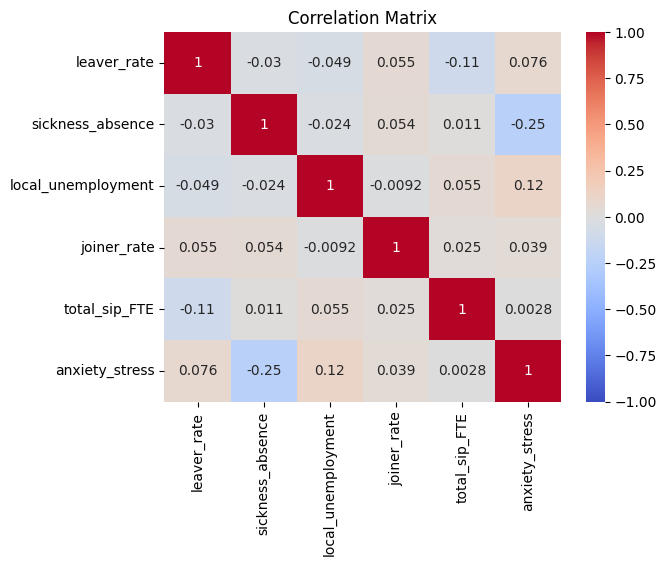

In [132]:
corr_cols = ['leaver_rate', 'sickness_absence',
                                   'local_unemployment','joiner_rate','total_sip_FTE','anxiety_stress']
correlation_matrix = df_leaver_r3[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Create a staff group level dataframe - specify which staff group you want from list below in variable staff_group

In [154]:
sgs = sorted(df_leaver_r3['staff_group'].unique())

In [134]:
staff_group = 'Nurses & health visitors'
df_sg = df_leaver_r3[df_leaver_r3['staff_group'] == staff_group].copy()

#df_sg['sickness_absence_rate'] = df_sg['FTE days lost']/df_sg['FTE days available']
#df_sg['leaver_rate'] = df_sg['leave_FTE']/df_sg['denom_FTE']

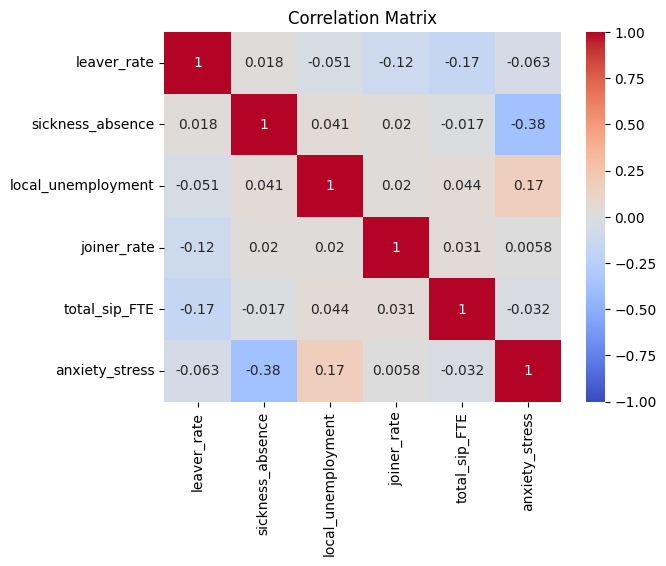

In [135]:
correlation_matrix = df_sg[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

(Optional) Create dummy variables for categorical independent variables

In [136]:
#ivs_cat = ['region_name','staff_group']
#df_with_dummies = pd.get_dummies(df_m, columns=ivs_cat, drop_first=True)
#df_with_dummies.head()

In [137]:
df_leaver_r3.to_csv(f'annual_modelling_data.csv', index=False)

In [138]:
#df_sg.to_csv(f'sg_modelling_data_to_check.csv', index=False)


Specify the dependent variable (dv) and independent variables (ivs). All other fields to be dropped. 

In [148]:
dv = 'leaver_rate'
#ivs = ['local_unemployment','sickness_absence_rate','joiner_rate','sip_FTE']
to_drop = ['month_year','org_code','region_name','org_type','staff_group',
           'join_FTE','leave_FTE','denom_FTE','fte_days_lost','gastro','other','pregnancy_related', dv]

Define the design matrix (X) and the dependent variable (y)


In [149]:
df_leaver_r3.reset_index(drop = True)
X = df_sg.drop(to_drop, axis=1)
y = df_sg[dv]

#y = y.dropna()

y.head()


53414    0.131000
53415    0.131000
53434    0.119250
53435    0.119250
53517    0.106662
Name: leaver_rate, dtype: float64

In [150]:

# Add a constant column to the design matrix
X = sm.add_constant(X)

X.tail()

# Convert True/False categories to integer 0/1
#bool_columns = X.select_dtypes(include='bool').columns
#X[bool_columns] = X[bool_columns].astype(int)


,const,joiner_rate,total_sip_FTE,local_unemployment,sickness_absence,anxiety_stress,back_problems,gynaecological,headache_mig,infectious_dis,other_msk,respiratory,unknown,month,year
312843,1.0,0.103012,4793.09804,0.034,0.056381,0.296121,0.046759,0.044905,0.029868,0.084031,0.096494,0.080637,0.031185,3,2023
312844,1.0,0.103012,4793.09804,0.048,0.056381,0.296121,0.046759,0.044905,0.029868,0.084031,0.096494,0.080637,0.031185,3,2023
312847,1.0,0.110279,10277.63607,0.043,0.049145,0.296121,0.046759,0.044905,0.029868,0.084031,0.096494,0.080637,0.031185,3,2023
312862,1.0,0.127962,3587.80211,0.037,0.060038,0.296121,0.046759,0.044905,0.029868,0.084031,0.096494,0.080637,0.031185,3,2023
312876,1.0,0.130105,3456.34357,0.043,0.051957,0.296121,0.046759,0.044905,0.029868,0.084031,0.096494,0.080637,0.031185,3,2023


In [152]:
# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            leaver_rate   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     115.0
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          9.88e-324
Time:                        16:13:48   Log-Likelihood:                 33953.
No. Observations:               22129   AIC:                        -6.788e+04
Df Residuals:                   22114   BIC:                        -6.776e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.2341      2

In [153]:

# Get the summary of the regression results
summary = results.summary()

# # Convert the summary table to a pandas DataFrame
# summary_df = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Format the coefficients and p-values
# summary_df['coef'] = summary_df['coef'].map('{:.4f}'.format)
# summary_df['P>|t|'] = summary_df['P>|t|'].map('{:.4f}'.format)

# Print the formatted summary table
print(summary.tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.2341      2.615      0.472      0.637      -3.892       6.360
joiner_rate           -0.0569      0.003    -16.395      0.000      -0.064      -0.050
total_sip_FTE      -2.724e-06   1.09e-07    -24.915      0.000   -2.94e-06   -2.51e-06
local_unemployment     0.1949      0.044      4.456      0.000       0.109       0.281
sickness_absence       0.0260      0.024      1.082      0.279      -0.021       0.073
anxiety_stress        -0.6944      0.050    -14.020      0.000      -0.791      -0.597
back_problems         -0.6638      0.194     -3.421      0.001      -1.044      -0.284
gynaecological        -1.3334      0.200     -6.673      0.000      -1.725      -0.942
headache_mig          -1.8075      0.275     -6.567      0.000      -2.347      -1.268
infectious_dis        -0.4236      0.039   

This model uses region and type of provider to try and predict NHS staff leaver FTE. The R squared is 0.054, meaning the factors in the model only explain 5.4% of the variation in the data. A lower adjusted R squared than R squared would tell us that some of the model's factors are not contibuting - this is not the case here. 
All variables contribute significantly except being in the Midlands region, NE and Yorkshire, North West or South West.  
The strongest predictors are CCG